In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [11]:
import torch
from tqdm.notebook import tqdm

#rom transformers import BertTokenizer
from transformers import XLMRobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#from transformers import BertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification
import pandas as pd
import numpy as np

from datasets import load_dataset

dataset = load_dataset('xnli', 'en')

In [3]:
import os
os.system("""wget "https://getfile.dokpub.com/yandex/get/https://disk.yandex.com/d/yMGxWRAyMU7k3Q" -O XNLI_en_.zip""")
os.system("unzip /content/XNLI_en_.zip -d /content")

0

In [12]:
model = XLMRobertaForSequenceClassification.from_pretrained("/content/XNLI_en_roberta",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=True)
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base',
                                          do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
class Pipeline:
    def __init__(self, model, tokenizer, model_language="en"):
        self.model = model
        self.tokenizer = tokenizer

        if torch.cuda.is_available():
            self.device = "cuda"
        else:
            self.device = "cpu"

        self.model = self.model.to(self.device)

    def get_neurons_activations(self, dataloader):
        self.model.eval()

        # Подготовка списка для хранения усредненных скрытых состояний по слоям
        avg_hidens_per_layer = [
            [] for _ in range(13)
        ]  # предполагается, что у модели 12 слоев + входной слой

        for batch in dataloader:
            batch = tuple(b.to(self.device) for b in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
            }

            with torch.no_grad():
                outputs = self.model(**inputs)

            # Создание маски для исключения [PAD] токенов (где input_ids равно 0)
            mask = (
                inputs["input_ids"] != 0
            )  # Создается маска размером как input_ids, True где не PAD
            mask = mask.unsqueeze(-1).expand_as(
                outputs["hidden_states"][0]
            )  # Расширение маски до размера скрытых состояний

            for layer_idx, layer_hidden_states in enumerate(outputs["hidden_states"]):
                # Применение маски к скрытым состояниям
                masked_hidden_states = layer_hidden_states * mask.float()
                # Вычисление суммы и количества не-pad токенов для усреднения
                sum_hidden_states = masked_hidden_states.sum(
                    dim=1
                )  # Сумма по оси токенов
                non_pad_tokens = mask.sum(dim=1)  # Количество не-pad токенов
                # Усреднение скрытых состояний, исключая pad-токены
                avg_hidden_states = sum_hidden_states / non_pad_tokens.clamp(
                    min=1
                )  # Избегание деления на 0
                avg_hidens_per_layer[layer_idx].append(avg_hidden_states)

        # Собираем усредненные скрытые состояния по всему датасету для каждого слоя
        avg_hidens_stacked_per_layer = [
            torch.cat(layer_avg_hidens, dim=0)
            for layer_avg_hidens in avg_hidens_per_layer
        ]

        # Стекинг усредненных скрытых состояний для всех слоев
        all_avg_hidens_tensor = torch.stack(avg_hidens_stacked_per_layer)

        return all_avg_hidens_tensor  # [layers, batch, neurons]

    def predict_dataloader(self, dataloader):
        self.model.eval()

        predictions = []

        for batch in dataloader:
            batch = tuple(b.to(self.device) for b in batch)

            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
            }

            with torch.no_grad():
                outputs = self.model(**inputs)

            logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            predictions.append(logits)

        predictions = np.concatenate(predictions, axis=0)

        return predictions

    def predict_proba(self, data):
        encoded_data_predict = self.tokenizer.batch_encode_plus(
            data,
            add_special_tokens=True,
            return_attention_mask=True,
            padding="max_length",
            max_length=512,
            truncation=True,
            return_tensors="pt",
        )

        input_ids_predict = encoded_data_predict["input_ids"]
        attention_masks_predict = encoded_data_predict["attention_mask"]
        dataset_predict = TensorDataset(input_ids_predict, attention_masks_predict)

        batch_size = 10
        dataloader_predict = DataLoader(
            dataset_predict,
            sampler=SequentialSampler(dataset_predict),
            batch_size=batch_size,
        )

        predictions = self.predict_dataloader(dataloader_predict)

        return predictions

    def predict(self, data):
        predictions = self.predict_proba(data)
        return np.argmax(predictions, axis=1).flatten()


In [14]:
predictor = Pipeline(model, tokenizer, 'en')

In [15]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

def plot_confusion_matrix(preds, labels, label_dict, language="en", model_lang=None):
    label_to_name = {value: key for key, value in label_dict.items()}

    # Вычисляем confusion matrix
    cm = confusion_matrix(labels, preds)
    label_names = list(label_dict.keys())

    # Визуализация confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm[::-1],
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_names,
        yticklabels=label_names[::-1],
        annot_kws={"size": 14},
    )
    f1_macro = round(f1_score(preds, labels, average="macro"), 2)
    if model_lang is None:
        plt.title(f"Выборка: {language}, f1 macro: {f1_macro}", size=20)
    else:
        plt.title(f"Модель: {model_lang}, Выборка: {language}, f1 macro: {f1_macro}", size=20)
    plt.ylabel("Истинные классы", size=16)
    plt.xlabel("Предсказанные классы", size=16)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    plt.show()

def bootstrap_f1_macro(preds, labels, n_iterations=10, n_samples=100):
    f1_scores = []
    for i in range(n_iterations):
        preds_resampled, labels_resampled = resample(preds, labels, replace=False, n_samples=n_samples)
        f1 = f1_score(labels_resampled, preds_resampled, average='macro')
        f1_scores.append(f1)
    return f1_scores

In [16]:
import random

def load_data(language, indixes):
    dataset = load_dataset('xnli', language, split='test')

    text = [f"[CLS] {dataset['premise'][i]} [SEP] {dataset['hypothesis'][i]} [SEP]" for i in indixes]
    labels = [dataset['label'][i] for i in indixes]
    return (text, labels)

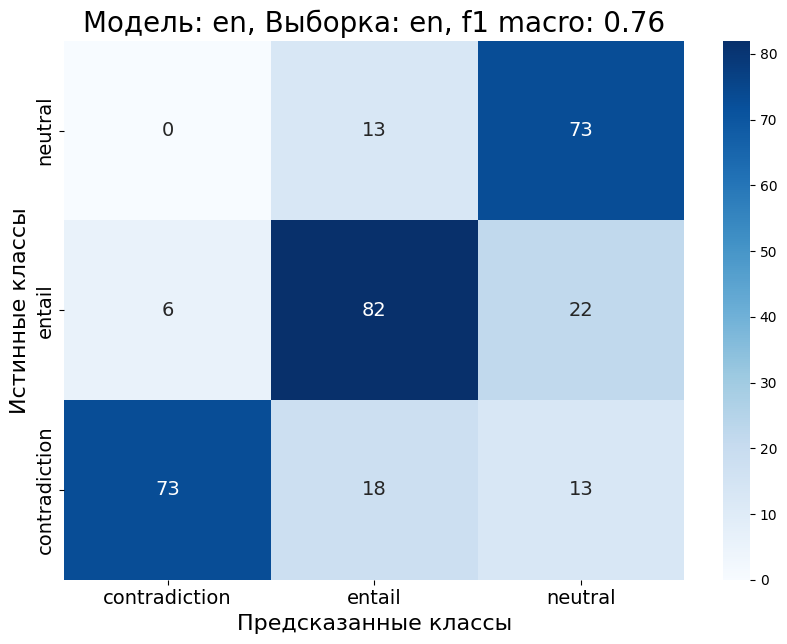

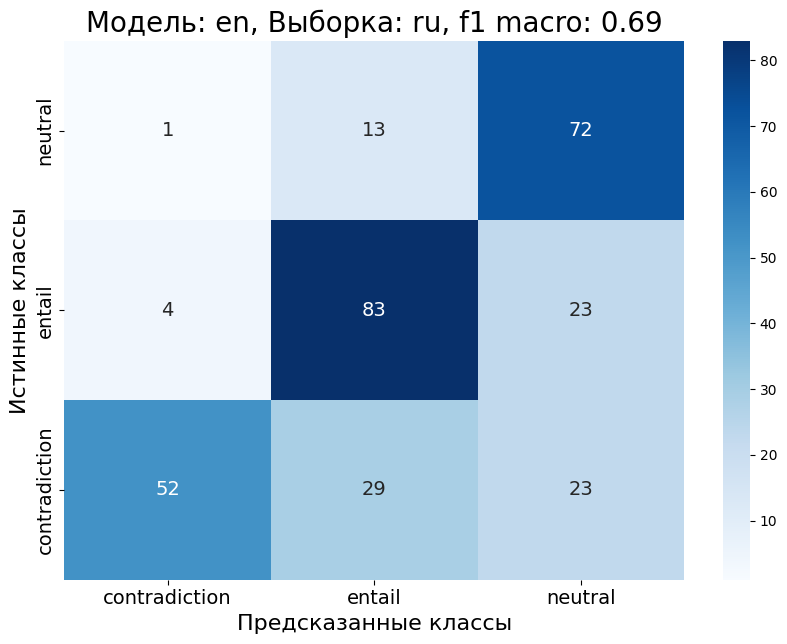

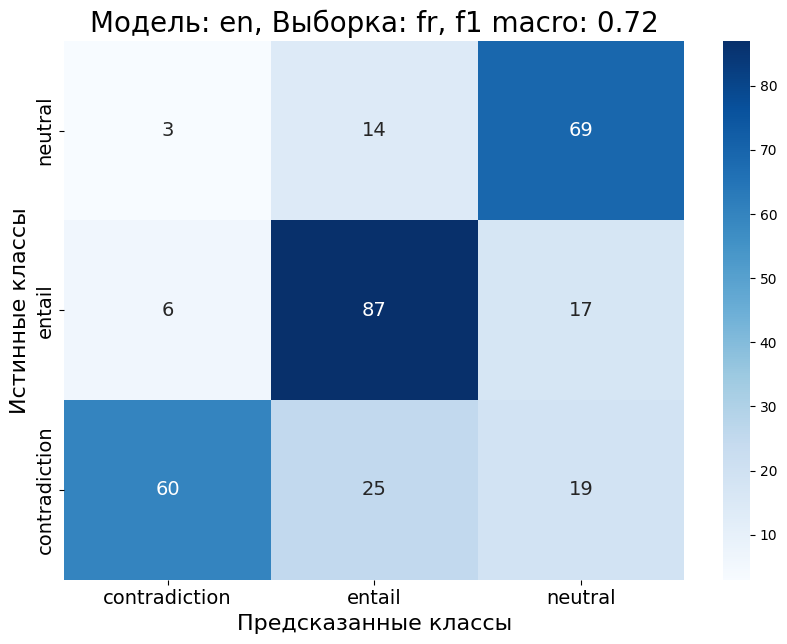

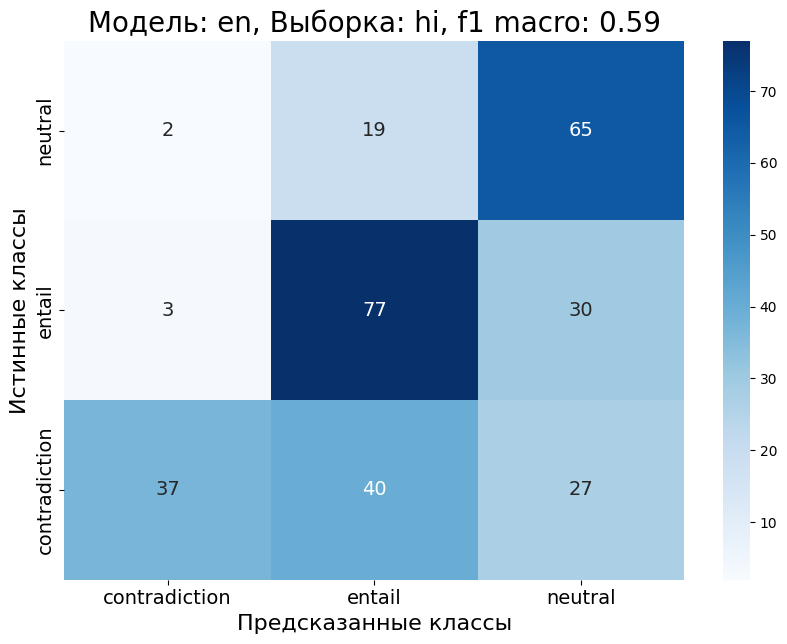

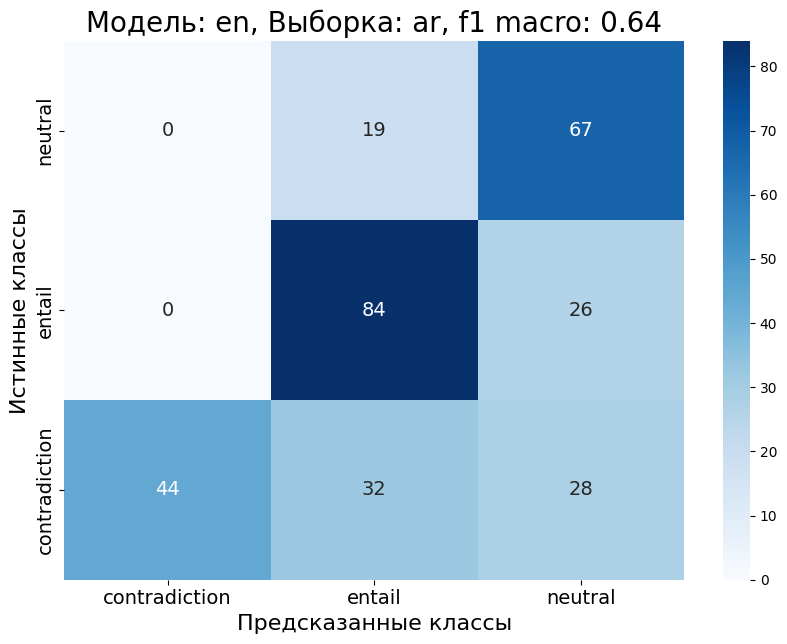

In [17]:
label_dict = {'contradiction': 0, 'entail': 1, 'neutral': 2}
n_samples = 300
random_indixes = random.sample(range(5010), n_samples)

for lang in ['en', 'ru', 'fr', 'hi', 'ar']:
    texts, labels = load_data(lang, random_indixes)

    preds = predictor.predict(texts)
    plot_confusion_matrix(preds, labels, label_dict, language=lang, model_lang='en')

In [18]:
f1_scores_all = []

for language in tqdm(['en', 'ru', 'fr', 'hi', 'ar'], desc="Languages"):
    texts, labels = load_data(lang, random_indixes)
    preds = predictor.predict(texts)
    f1_scores = bootstrap_f1_macro(preds, labels, n_iterations=10)
    f1_scores_all.append({
            'Value': f1_scores,
            'Language': language
        })

df_f1_scores = pd.DataFrame(f1_scores_all)
df_f1_scores.to_csv('XNLI_roberta.csv', index=False)

Languages:   0%|          | 0/5 [00:00<?, ?it/s]